<a href="https://colab.research.google.com/github/lenaklwt/retail_demand_analysis/blob/main/1_data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0 Daten laden

In [ ]:
# STEP 0: Install gdown
!pip install -U gdown

# STEP 1: Imports and helper functions
import pandas as pd
import requests
import io
import gdown

# Build the download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

# STEP 2: Dictionary of file IDs
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

# STEP 3: Read all files but train.csv
# Load each CSV using the helper functions
df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
df_train          = load_csv_from_url(make_drive_url(file_ids["train"]))
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))

# STEP 4: Download the train.csv file using gdown
train_url = make_drive_url(file_ids["train"])
gdown.download(train_url, "train.csv", quiet=False)

# STEP 5: Load stores and get Guayas store IDs
stores_url = make_drive_url(file_ids["stores"])
df_stores = pd.read_csv(io.StringIO(requests.get(stores_url).text))
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# STEP 6: Read train.csv in chunks and filter for Guayas region
chunk_size = 10**6
filtered_chunks = []

for chunk in pd.read_csv("train.csv", chunksize=chunk_size):
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    filtered_chunks.append(chunk_filtered)
    del chunk

# STEP 7: Combine and sample
df_train = pd.concat(filtered_chunks, ignore_index=True).sample(n=3_000_000).reset_index(drop=True)

# STEP 8: Clean up memory
del filtered_chunks


  1%|          | 29.4M/5.00G [00:19<03:08, 26.3MB/s]Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=c6724b67-9e5c-4fcd-b757-4c0dcea5493f
To: /content/train.csv

  0%|          | 0.00/5.00G [00:00<?, ?B/s]
  0%|          | 4.72M/5.00G [00:00<05:42, 14.6MB/s]
  0%|          | 15.2M/5.00G [00:00<02:54, 28.6MB/s]
  1%|          | 36.2M/5.00G [00:00<01:16, 64.5MB/s]
  1%|          | 50.9M/5.00G [00:01<01:32, 53.6MB/s]
  1%|▏         | 72.4M/5.00G [00:01<01:00, 81.5MB/s]
  2%|▏         | 84.4M/5.00G [00:01<01:09, 70.6MB/s]
  2%|▏         | 101M/5.00G [00:01<01:14, 65.9MB/s] 
  2%|▏         | 122M/5.00G [00:01<00:54, 89.4MB/s]
  3%|▎         | 135M/5.00G [00:01<00:52, 92.1MB/s]
  3%|▎         | 155M/5.00G [00:02<00:42, 115MB/s] 
  3%|▎         | 171M/5.00G [00:02<00:38, 125MB/s]
  4%|▎         | 186M/5.00G [00:02<00:45, 105MB/s]
  4%|▍         | 2

In [ ]:
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)

In [ ]:
top_3_families

,Family,Item Count
0,GROCERY I,1334
1,BEVERAGES,613
2,CLEANING,446


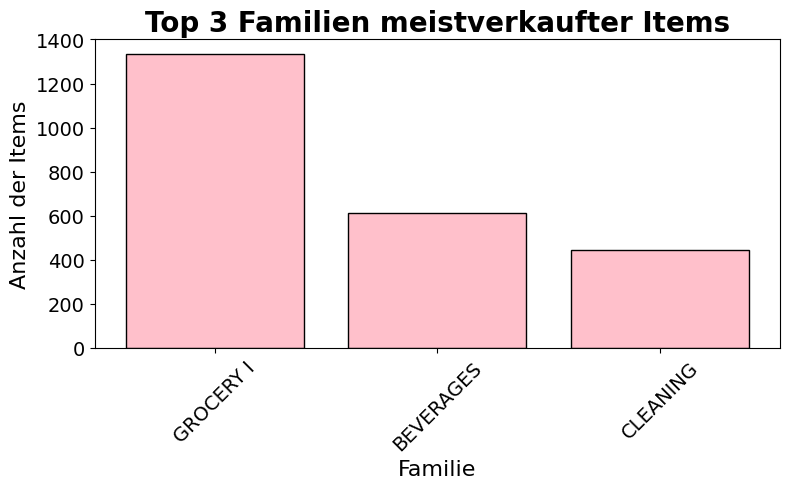

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(top_3_families['Family'], top_3_families['Item Count'], color='pink', edgecolor='black')
plt.title("Top 3 Familien meistverkaufter Items", fontsize=20, fontweight='bold')
plt.xlabel("Familie", fontsize=16)
plt.ylabel("Anzahl der Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()

In [ ]:
df_train = df_train[df_train['item_nbr'].isin(item_ids)]

Tägliche Verkaufszahlen nach Filiale und Produkt:
- unit_sales kann eine ganze Zahl (z. B. eine Tüte Chips) oder eine Gleitkommazahl (z. B. 1,5 kg Käse) sein
- Negative Werte stellen Rücksendungen des jeweiligen Artikels dar


In [ ]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,10065692,2013-08-22,27,502067,3.0,NaN
2,71778822,2016-02-27,32,700607,1.0,False
3,95204387,2016-10-28,35,1464312,1.0,False
4,2695364,2013-03-08,28,1109389,5.0,NaN
5,63780879,2015-12-02,51,2011073,3.0,False


Details zu jedem Artikel:
- perishable = verderblich
- Mit einem Sternchen gekennzeichnete Elemente haben eine Gewichtung von  1.25; andernfalls beträgt die Gewichtung  1.0


In [ ]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


Filialen und Filialtypen:
- cluster ist eine Gruppe ähnlicher Geschäfte


In [ ]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Ölpreise (ein möglicher externer Einflussfaktor auf den Absatz):
- Ecuador ist ein vom Öl abhängiges Land und seine Wirtschaft reagiert äußerst empfindlich auf Ölpreisschwankungen.

In [ ]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


Gesamtkundenverkehr pro Tag:

In [ ]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


Nationale/lokale Feiertage und besondere Ereignisse:
- Feiertage sind Tage, die einem regulären Kalenderfeiertag hinzugefügt werden, wie es typischerweise um Weihnachten herum der Fall ist (wodurch der Heiligabend zu einem Feiertag wird)


> Beachten Sie besonders die Spalte „transferred“. Ein verschobener Feiertag fällt offiziell auf diesen Kalendertag, wurde aber von der Regierung auf ein anderes Datum verlegt. Ein verschobener Tag ist eher ein normaler Arbeitstag als ein Feiertag. Um den tatsächlichen Feiertag zu finden, suchen Sie die entsprechende Zeile mit dem Typ „Transfer“. Beispielsweise wurde der Feiertag „Independencia de Guayaquil“ vom 9. Oktober 2012 auf den 12. Oktober 2012 verschoben und fand somit am 12. Oktober 2012 statt. Tage vom Typ „Bridge“ sind zusätzliche Tage, die an einen Feiertag angehängt werden (z. B. um die Ferien über ein verlängertes Wochenende auszudehnen). Diese werden häufig durch Arbeitstage ausgeglichen, also Tage, an denen normalerweise nicht gearbeitet wird (z. B. Samstag), um die „Bridge“ auszugleichen.






In [ ]:
df_holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


**Zusätzliche Anmerkungen**
- Die Löhne im öffentlichen Dienst werden alle zwei Wochen, am 15. und am letzten Tag des Monats, ausgezahlt. Dies könnte sich auf die Umsätze der Supermärkte auswirken.
- Am 16. April 2016 erschütterte ein Erdbeben der Stärke 7,8 Ecuador. Die Bevölkerung beteiligte sich an Hilfsmaßnahmen und spendete Wasser und andere lebensnotwendige Güter, was die Supermarktumsätze mehrere Wochen nach dem Erdbeben stark beeinträchtigte.

In [ ]:
df_train.to_parquet('/content/drive/MyDrive/TimeSeries/df_train_filtered.parquet')


#1 Exploration & Feature-Engineering

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

In [3]:
base_path = '/content/drive/MyDrive/TimeSeries/'

df_holiday_events = pd.read_parquet(f'{base_path}holiday_events.parquet')
df_items          = pd.read_parquet(f'{base_path}items.parquet')
df_oil            = pd.read_parquet(f'{base_path}oil.parquet')
df_stores         = pd.read_parquet(f'{base_path}stores.parquet')
df_transactions   = pd.read_parquet(f'{base_path}transactions.parquet')

In [4]:
df_train = pd.read_parquet('/content/drive/MyDrive/TimeSeries/df_train_filtered.parquet')

##1.1 Überprüfung auf fehlende Daten

In [5]:
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0



Werbeaktionen sind eher selten, daher enthält die Spalte „onpromotion“ viele NaN-Werte, die wir durch „False“ ersetzen möchten.

In [6]:
df_train['onpromotion'] = (df_train['onpromotion'].fillna(False).infer_objects(copy=False).astype(bool))

In [7]:
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0


In [8]:
df_stores.isna().sum()

,0
store_nbr,0
city,0
state,0
type,0
cluster,0


In [9]:
df_items.isna().sum()

,0
item_nbr,0
family,0
class,0
perishable,0


In [10]:
df_transactions.isna().sum()

,0
date,0
store_nbr,0
transactions,0


In [11]:
df_holiday_events.isna().sum()

,0
date,0
type,0
locale,0
locale_name,0
description,0
transferred,0


In [12]:
df_oil.isna().sum()

,0
date,0
dcoilwtico,43


Die Spalte dcoilwtico ist sehr wahrscheinlich der EIA-Code (U.S. Energy Information Administration) für eine bestimmte Rohöl-Zeitreihe.

In [ ]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [13]:
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_oil = df_oil.set_index('date')

Die Interpolation erfolgt linear in Bezug auf die Zeit, d. h. fehlende Werte werden proportional zu den zeitlichen Abständen geschätzt.

In [14]:
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='time')

Dies füllt alle fehlenden Werte (NaN) in der Spalte dcoilwtico durch Backfill (Rückwärtsauffüllen).

Backfill bedeutet: Ein fehlender Wert wird durch den nächsten verfügbaren Wert unterhalb (zeitlich später) ersetzt.

In [15]:
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].bfill()

In [16]:
df_oil.isna().sum()

,0
dcoilwtico,0


In [17]:
df_train['date'] = pd.to_datetime(df_train['date'])

all_days = pd.date_range(df_train['date'].min(), df_train['date'].max())
missing_global = all_days.difference(df_train['date'].unique())

missing_global

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-01-01', '2015-12-25',
               '2016-01-01', '2016-12-25', '2017-01-01'],
              dtype='datetime64[ns]', freq=None)

##1.2 Umgang mit Ausreißern

###Produktrückgaben/Negative Umsätze

In [18]:
negative_sales = df_train[df_train['unit_sales'] < 0]
negative_sales.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
24836,99196019,2016-12-07,26,323013,-130.0,False
40318,99919107,2016-12-14,29,265086,-156.0,False
46594,122458304,2017-07-17,51,1354381,-1.0,False
52216,51126981,2015-07-11,24,1105215,-1.0,False
74993,118962519,2017-06-14,51,1946311,-1.0,False


In [19]:
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

In [20]:
df_train[df_train['unit_sales'] < 0]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion


###Extrem hohe Umsätze

In [21]:
def calculate_store_item_zscore(group):
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

In [22]:
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

/tmp/ipython-input-3380579669.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


In [ ]:
#df_train_grouped = (df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore, include_groups=False).reset_index(drop=True))

In [23]:
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

In [24]:
print(f"Gefundene Ausreißer: {len(outliers)}")
outliers.head()

Gefundene Ausreißer: 5968


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
282,9192700,2013-08-03,24,105574,58.0,False,6.083211
322,58206382,2015-10-03,24,105574,55.0,False,5.690470
427,65140543,2015-12-17,24,105575,420.0,False,13.874161
863,76849629,2016-04-20,24,105693,20.0,False,5.782104
919,68200085,2016-01-20,24,105737,40.0,False,5.006336


Es gibt viele dieser Werte, aber sie sehen nicht wie Fehler aus. Das sind einfach große Umsätze.

##1.3 Fehlende Daten mit Nullumsätzen auffüllen

In [25]:
df_train['date'] = pd.to_datetime(df_train['date'])

In [26]:
min_date = df_train['date'].min()
max_date = df_train['date'].max()

In [27]:
pd.date_range(min_date, max_date, freq='D')

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05',
               '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09',
               '2013-01-10', '2013-01-11',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1687, freq='D')

In [28]:
full_data_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})

In [29]:
full_data_range

,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-06
...,...
1682,2017-08-11
1683,2017-08-12
1684,2017-08-13
1685,2017-08-14


In [30]:
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_data_range, how='cross')
all_combinations

,store_nbr,item_nbr,date
0,27,502067,2013-01-02
1,27,502067,2013-01-03
2,27,502067,2013-01-04
3,27,502067,2013-01-05
4,27,502067,2013-01-06
...,...,...,...
34689776,32,940665,2017-08-11
34689777,32,940665,2017-08-12
34689778,32,940665,2017-08-13
34689779,32,940665,2017-08-14


In [31]:
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')

In [32]:
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)

In [33]:
df_filled.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,27,502067,2013-01-02,NaN,0.0,NaN
1,27,502067,2013-01-03,NaN,0.0,NaN
2,27,502067,2013-01-04,NaN,0.0,NaN
3,27,502067,2013-01-05,NaN,0.0,NaN
4,27,502067,2013-01-06,NaN,0.0,NaN


In [34]:
df_train = df_filled
del df_filled

## 1.4 Umwandlung eines Datums in nützliche Signale

**year**
- Erfasst langfristiges Wachstum oder Rückgang, z. B. steigende Umsätze jedes Jahr.

**month**
- Erreicht die Feiertagszeiten (November-Dezember), die Spitzenzeiten zum Schulbeginn usw.

**day**
- Nützlich bei Gehaltsspitzen zum Monatsende oder zur Monatsmitte.

**day_of_week**
- Zeigt Muster im Vergleich zu Wochentagen auf – Freitags großer Ansturm auf Lebensmittelgeschäfte, sonntags Flaute.

*Monday=0 … Sunday=6*

In [35]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,27,502067,2013-01-02,NaN,0.0,NaN
1,27,502067,2013-01-03,NaN,0.0,NaN
2,27,502067,2013-01-04,NaN,0.0,NaN
3,27,502067,2013-01-05,NaN,0.0,NaN
4,27,502067,2013-01-06,NaN,0.0,NaN


In [36]:
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek

In [37]:
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())

In [38]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,27,502067,2013-01-02,NaN,0.0,NaN,2013,1,2,2,NaN
1,27,502067,2013-01-03,NaN,0.0,NaN,2013,1,3,3,NaN
2,27,502067,2013-01-04,NaN,0.0,NaN,2013,1,4,4,NaN
3,27,502067,2013-01-05,NaN,0.0,NaN,2013,1,5,5,NaN
4,27,502067,2013-01-06,NaN,0.0,NaN,2013,1,6,6,NaN


##1.5 Visualisierung von Zeitreihendaten

In [39]:
import matplotlib.pyplot as plt

In [40]:
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

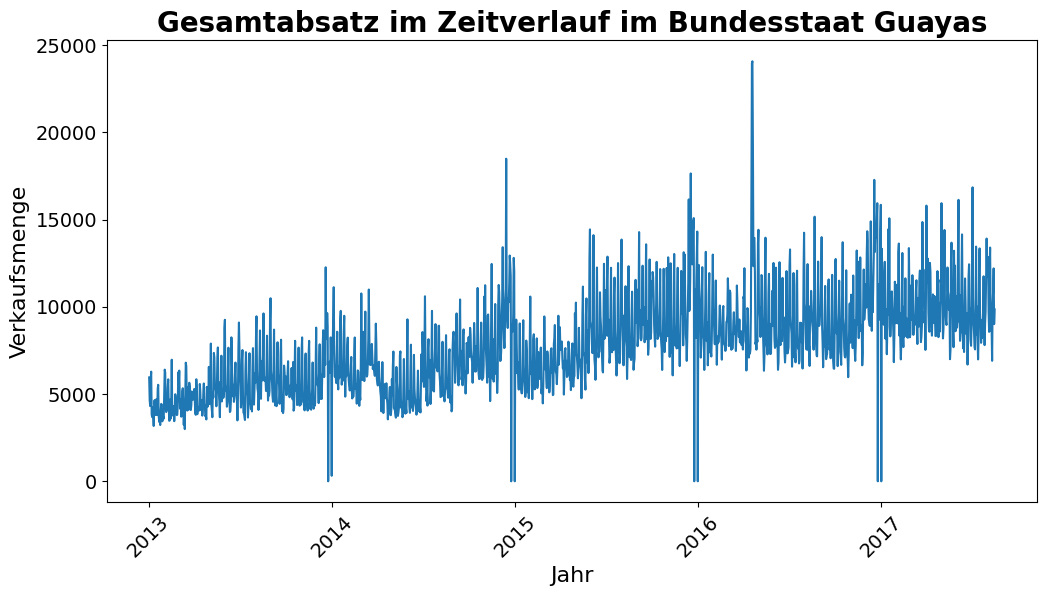

In [41]:
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Gesamtabsatz im Zeitverlauf im Bundesstaat Guayas', fontsize=20, fontweight='bold')
plt.xlabel('Jahr', fontsize=16)
plt.ylabel('Verkaufsmenge', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

In [42]:
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

In [43]:
import seaborn as sns

Text(70.72222222222221, 0.5, 'Jahr')

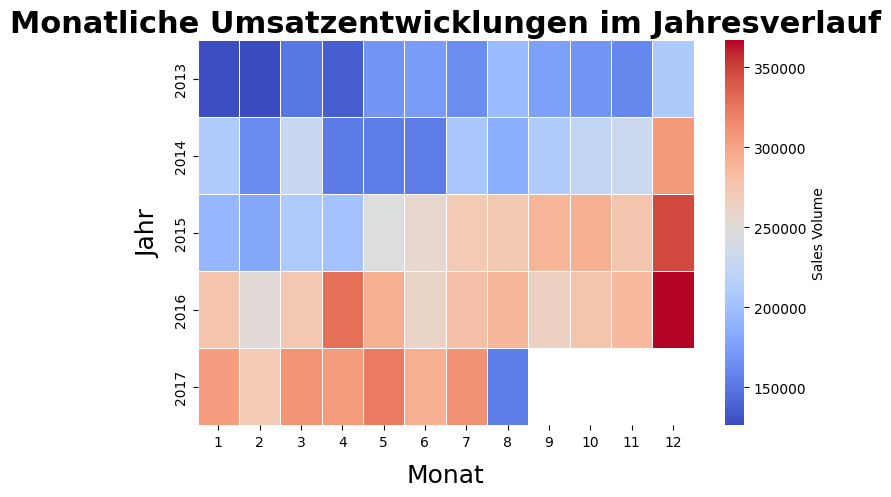

In [44]:
plt.figure(figsize=(8, 5))
sns.heatmap(sales_by_month,cmap='coolwarm',linewidths=0.5,linecolor='white',cbar_kws={'label': 'Sales Volume'})
plt.title('Monatliche Umsatzentwicklungen im Jahresverlauf', fontsize=22, fontweight='bold')
plt.xlabel('Monat', fontsize=18, labelpad=10)
plt.ylabel('Jahr', fontsize=18, labelpad=10)

##1.6 Untersuchung der Auswirkungen von Feiertagen

In [45]:
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])
print("Der Urlaubszeitraum ist von ",df_holiday_events['date'].dt.date.min(),"bis",df_holiday_events['date'].dt.date.max())

Der Urlaubszeitraum ist von  2012-03-02 bis 2017-12-26


In [46]:
df_train_no_zero = df_train[df_train.unit_sales > 0]

In [47]:
df_train_holiday = pd.merge(df_train_no_zero, df_holiday_events, on='date', how='left')

In [48]:
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

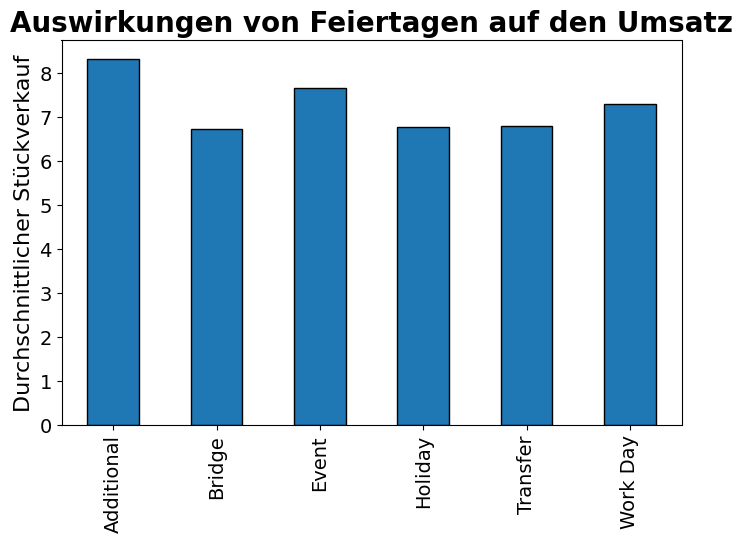

In [49]:
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', edgecolor='black')
plt.title('Auswirkungen von Feiertagen auf den Umsatz', fontsize=20, fontweight='bold')
plt.ylabel('Durchschnittlicher Stückverkauf', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

##1.7 Analyse verderblicher Waren


In [50]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [51]:
df_items['perishable'].value_counts()


,count
perishable,
0,3114
1,986


In [ ]:
df_items['perishable'] = df_items['perishable'].astype(bool)


In [ ]:
df_items['perishable'].value_counts()

,count
perishable,
False,3114
True,986


In [ ]:
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')

In [ ]:
df_train_items['perishable'].unique()

array([False])

In [14]:
perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()

In [15]:
perishable_sales

,unit_sales
perishable,
False,1.312590e+07


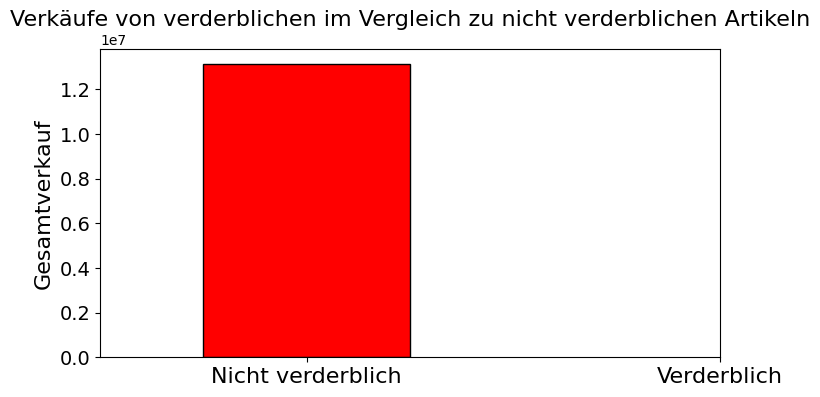

In [ ]:
plt.figure(figsize=(8,4))
perishable_sales.plot(kind='bar', color=['red', 'green'], edgecolor='black')
plt.title('Verkäufe von verderblichen im Vergleich zu nicht verderblichen Artikeln', fontsize=16)
plt.ylabel('Gesamtverkauf', fontsize=16)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1],
    labels=['Nicht verderblich', 'Verderblich'],
    fontsize=16,
    rotation=0)
plt.yticks(fontsize=14)
plt.show()

## 1.8 Analyse von Auswirkungen der Ölpreise

https://app.masterschool.com/campus/lesson/Case-Study--Demand-forecasting-in-retail-5e4b/Step-8--Analyzing-the-Impact-of-Oil-Prices-063b

Wichtig – Die Vorlesungen sind nur Ihr Startpunkt
Im Kurs haben wir die grundlegenden Schritte behandelt – grundlegende Datenbereinigung, Kalenderfüllungen und einige Feature-Ideen –, um Ihnen den Umgang mit Zeitreihendaten zu zeigen. Doch echte Erkenntnisse (und eine höhere Modellgenauigkeit) erhält man durch weiterführende Analysen:
Verknüpfen Sie mehrere Tabellen: Versuchen Sie es beispielsweise mit Ölpreisen nach Geschäftsregion, Transaktionszahlen oder Wetterdaten, falls Sie diese finden können.
Stellen Sie neue Fragen: Wirken sich Werbeaktionen unterschiedlich auf die Nachfrage nach verderblichen bzw. nicht verderblichen Waren aus? Führt die Woche vor dem Zahltag zu einem Nachfrageanstieg in bestimmten Produktkategorien?
Erfinden Sie individuelle Funktionen: Flaggen für Fußballspieltage, kumulierte Monatsumsätze oder einen Zähler für die Tage seit dem letzten Warenausverkauf.
Betrachten Sie das Notizbuch als Spielwiese – experimentieren Sie, verbessern Sie Ihre Vorgehensweise und dokumentieren Sie Ihre Erkenntnisse. Je mehr Aspekte Sie jetzt erkunden, desto solider (und besser zu verteidigen) wird Ihr Modell später sein.

## Speichern

In [ ]:
df_train.to_csv('/content/drive/MyDrive/TimeSeries/guayas_prepared.csv', index=False)
